In [3]:
%ls

data/     fe_data_new/  random_forest_pipline.ipynb
fe_data/  fe_data_v2/   random_forest_testing.ipynb


In [4]:
%cd asurion_f22_wut


[Errno 2] No such file or directory: 'asurion_f22_wut'
/workspace/asurion_f22_wut


In [5]:
%ls

data/     fe_data_new/  random_forest_pipline.ipynb
fe_data/  fe_data_v2/   random_forest_testing.ipynb


In [6]:
%cd fe_data_v2

/workspace/asurion_f22_wut/fe_data_v2


In [7]:
%ls

30_day_churn_data/  90_day_churn_data/  total_data/
7_day_churn_data/   sale_data/


In [8]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('sale_data/test_sale_encoded.csv', index_col='id')

In [10]:
df_col= ['accepted_flg', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'hh_income_code', 'month']

In [11]:
df.drop(columns = df_col, inplace = True)
df = df[(df['zipcode_accepted_prop'].isnull()==False)& (df['zipcode_rejected_offers'].isnull()==False)& 
            (df['zipcode_accepted_offers'].isnull()==False)&(df['zipcode_total_offers'].isnull()==False)]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223145 entries, c27e6b798c0ae161fad4a807f097dd233a52c7b8d72c777799c0bec9 to eabb5d70312e1d7e2e240318f84bab3fd1803639bd43cf7d1d65f712
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   quality_sale                223145 non-null  int64  
 1   lines                       223145 non-null  int64  
 2   previous_tech_support_call  223145 non-null  int64  
 3   account_tenure              223145 non-null  int64  
 4   past_yr_claim_count         223145 non-null  int64  
 5   num_decline                 223145 non-null  int64  
 6   exp                         223145 non-null  int64  
 7   product_type                223145 non-null  object 
 8   pmake                       223145 non-null  object 
 9   claritas_hh_count           223145 non-null  int64  
 10  technodoption_class         223145 non-null  object 
 11  hh_income                   22

In [13]:
df.to_csv('sale_data/testing.csv')

In [14]:
train_df = pd.read_csv('sale_data/train_sale_encoded.csv', index_col='id')

In [15]:
train_df.drop(columns = df_col, inplace = True)
train_df = train_df[(train_df['zipcode_accepted_prop'].isnull()==False)& (train_df['zipcode_rejected_offers'].isnull()==False)& 
            (train_df['zipcode_accepted_offers'].isnull()==False)&(train_df['zipcode_total_offers'].isnull()==False)]

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 863505 entries, c90ce3eaafffd07a32cb9cf4d153aef6f524b29aeef447ba3200efdb to 66b4c3759f378f38589395fd0353856239da965077903f31b30e87fc
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   quality_sale                863505 non-null  int64  
 1   lines                       863505 non-null  int64  
 2   previous_tech_support_call  863505 non-null  int64  
 3   account_tenure              863505 non-null  int64  
 4   past_yr_claim_count         863505 non-null  int64  
 5   num_decline                 863505 non-null  int64  
 6   exp                         863505 non-null  int64  
 7   product_type                863505 non-null  object 
 8   pmake                       863505 non-null  object 
 9   claritas_hh_count           863505 non-null  int64  
 10  technodoption_class         863505 non-null  object 
 11  hh_income                   86

In [17]:
train_df.to_csv('sale_data/training.csv')

In [18]:
train_df.shape

(863505, 31)

In [19]:
num_list = ['lines', 'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count', 'num_decline', 
            'claritas_hh_count', 'median_income', 'total_population', 'perc_female', 'perc_under18',
            'perc_over65', 'perc_white', 'perc_black', 'population_density',
            'zipcode_accepted_prop', 'zipcode_rejected_offers', 'zipcode_accepted_offers', 'zipcode_total_offers']
cat_list = ['exp', 'product_type', 'pmake', 'technodoption_class', 'hh_income', 'age_class', 'hh_education', 
            'hh_composition', 'hh_tenure', 'urbanicity', 'day_of_week', 'time_of_day']
len(num_list+cat_list)

30

In [20]:
train = pd.read_csv('sale_data/training.csv', index_col='id')
test = pd.read_csv('sale_data/testing.csv', index_col='id')

In [21]:
train.columns

Index(['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [22]:
test.columns

Index(['quality_sale', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers'],
      dtype='object')

In [23]:
class_column = 'quality_sale'
random_seed = 42
data = train.copy()
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=class_column), data[class_column],
                                                   test_size=0.3, random_state=random_seed, stratify=data[class_column])

In [24]:
onehot = OneHotEncoder(handle_unknown='ignore')
minmax = MinMaxScaler()
ct = ColumnTransformer([("onehot", onehot, cat_list),("minmax", minmax, num_list)])
pipeline = Pipeline([("col", ct), ("mdl", RandomForestClassifier(class_weight='balanced'))])

In [35]:
tuning_grid = {'mdl__n_estimators' : [10],
               'mdl__max_depth' : [2,3,4],
               'mdl__min_samples_split': [2,5,10],
               'mdl__min_samples_leaf': [1,2,5]
                }
grid_search = GridSearchCV(pipeline, param_grid = tuning_grid, cv = 5, return_train_score=True,  verbose = 1, 
                      n_jobs = -1, scoring = 'recall')
start=time.time()
grid_search.fit(X_train, y_train)
print('best score for grid search:', grid_search.best_score_)

display(grid_search.best_params_)
print('Timer:', time.time()-start, 'seconds')
random_forest_classifier = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best score for grid search: 0.7822255485180576


{'mdl__max_depth': 3,
 'mdl__min_samples_leaf': 2,
 'mdl__min_samples_split': 2,
 'mdl__n_estimators': 10}

Timer: 170.7116858959198 seconds


In [36]:
#y_pred = random_forest_classifier.predict(X_test)
preds = random_forest_classifier.predict_proba(X_test)

In [37]:
print(preds)

[[0.45070278 0.54929722]
 [0.46328393 0.53671607]
 [0.62356915 0.37643085]
 ...
 [0.46615092 0.53384908]
 [0.62356915 0.37643085]
 [0.42662408 0.57337592]]


In [38]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
#print(np.unique(predictions, return_counts = True))
#print(np.unique(y_pred, return_counts = True))
#print(y_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("random_forest",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

random_forest 
 recall: 0.7508681991069952 
 precision: 0.13847526247169423 
 f1score: 0.23382793137854452 
 tn:121869, fp:112995, fn:6026, tp:18162 



In [39]:
%pwd

'/workspace/asurion_f22_wut/fe_data_v2'

In [40]:
joblib.dump(random_forest_classifier, 'random_forest_classifier_final.pkl')

['random_forest_classifier_final.pkl']

In [41]:
x = test.drop(columns=class_column)
y = test[class_column]

In [42]:
mymodel = joblib.load('random_forest_classifier_final.pkl')

In [43]:
preds = mymodel.predict_proba(x)

In [44]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("xgboost_test_july",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

xgboost_test_july 
 recall: 0.6001727613014685 
 precision: 0.09421953821396929 
 f1score: 0.162870470936638 
 tn:105588, fp:100192, fn:6943, tp:10422 



In [46]:
#get vip info
vip = random_forest_classifier.steps[1][1].feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':list(random_forest_classifier.steps[0][1].transformers_[0][1].get_feature_names())+num_list, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(10)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
zipcode_accepted_prop,0.31,0.31,1.00
zipcode_accepted_offers,0.10,0.10,1.00
x3_Unknown,0.06,0.06,1.00
x5_Unknown,0.05,0.05,1.00
x1_SD,0.05,0.05,1.00
x6_4 High School,0.04,0.04,1.00
x4_Unknown,0.04,0.04,1.00
x6_Unknown,0.03,0.03,1.00
x8_Unknown,0.03,0.03,1.00


In [47]:
feature_importances_info.to_csv('feature_importances.csv')

In [48]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 285 kB 4.2 MB/s eta 0:00:01


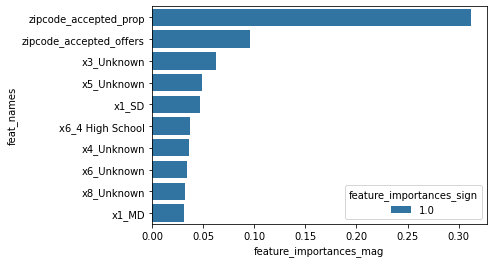

In [49]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);